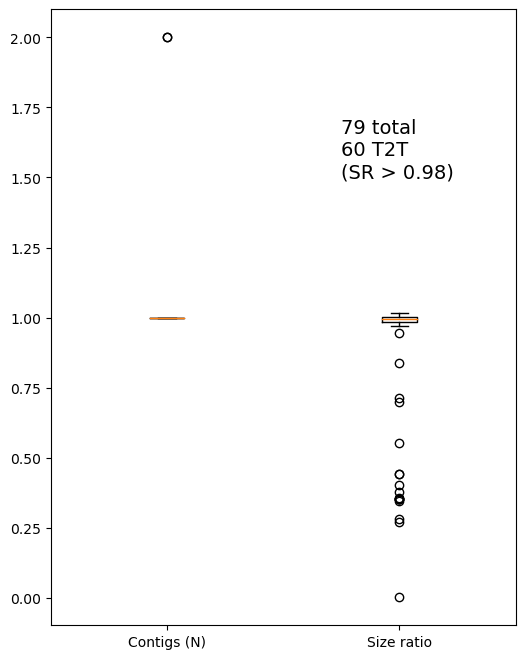

In [86]:
import pathlib as pl
import pandas as pd
import collections as col
import hashlib as hl
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

hla_chrom = "chr6"
hla_start = 29594784
hla_end = 32950465

def get_tigs():

    input_path = pl.Path("/home/ebertp/work/projects/hgsvc/2023_ctgref_align")
    use_columns = [
        "query_name", "query_length",
        "target_name", "target_start", "target_end",
        "tp_align_type", "target_length"
    ]
    
    out_table = []
    for paf_file in sorted(input_path.glob("*norm-paf.tsv.gz")):
        sample = paf_file.name.split(".")[0]
        hap = paf_file.name.split(".")[2].split("-")[-1]
        paf = pd.read_csv(paf_file, sep="\t", header=0, comment="#", usecols=use_columns)
        paf = paf.loc[(paf["tp_align_type"] == 1) & (paf["target_name"] == "chr6"), :].copy()
        paf = paf.loc[(paf["target_end"] > hla_start) & (paf["target_start"] < hla_end), :].copy()
        paf["ratio"] = (paf["query_length"] / paf["target_length"]).round(3)
                
        num_contigs = paf["query_name"].nunique()
        
        for query, aln in paf.groupby("query_name"):
            num_aln = aln.shape[0]
            ratio = aln["ratio"].values[0]
            out_table.append((sample, hap, num_contigs, query, num_aln, ratio))
    
    out_table = pd.DataFrame.from_records(
        out_table,
        columns=["sample", "hap", "num_contigs", "contig_name", "num_align", "size_ratio"]
    )
    
    box_num_contigs = out_table.drop_duplicates(keep="first", inplace=False)["num_contigs"].values
    box_size_ratio = out_table["size_ratio"].values
    
    total = box_size_ratio.size
    frac_t2t = sum(box_size_ratio > 0.98)
        
    fig, ax = plt.subplots(figsize=(6,8))
    
    ax.boxplot(
        (box_num_contigs, box_size_ratio),
        positions=[1,2],
        meanline=True,
        labels=["Contigs (N)", "Size ratio"]
    )
    ax.text(1.75, 1.5, f"{total} total\n{frac_t2t} T2T\n(SR > 0.98)", fontsize=14)

    return

_ = get_tigs()


def plot_coverage():

    input_path = pl.Path("/home/ebertp/work/projects/hgsvc/2023_ctgref_cov/t2tv2")
    
    coverages = []
    ylabels = []
    yticks = []

    region_begin = None
    region_end = None

    row_pos = 0
    for tsv_file in sorted(input_path.glob("*.tsv.gz")):
        df = pd.read_csv(tsv_file, sep="\t", header=[0,1,2], index_col=[0,1,2])
        df = df.loc[df.index.get_level_values("chrom") == "chr6", :].copy()
        df = df.droplevel("chrom", axis=0)
        df.reset_index(drop=False, inplace=True)
        df["start"] = df["start"].astype(int)
        offset = df["start"].min()
        df["end"] = df["end"].astype(int)
        df = df.loc[(df["start"] < hla_end) & (df["end"] > hla_start), :].copy()
        region_begin = df["start"].min()
        region_end = df["end"].max()
        sample = tsv_file.name.split(".")[0]

        for unit in ["hap1", "hap2", "unassigned"]:
            for mq in ["MQ60"]:
                values = df.loc[:, (f"asm-{unit}", mq, "ctg_align_cov")].values
                values = np.clip(values, 0, 3)  # everything > 2 is just "high"
                coverages.append(values)
                #labels.append(f"{sample} / {unit} / {mq}")
                if unit == "hap2":
                    ylabels.append(f"{sample}")
                    yticks.append(row_pos)
                row_pos += 1

    xpos = []
    xlabels = []

    for i in range(region_begin, region_end, 10000):
        if i % 500000 == 0:
            xpos.append(int((i - region_begin)/10000))
            xlabels.append(f"{i/1e6}")

    coverages = np.vstack(coverages)

    colormap = colors.ListedColormap(["white", "blue", "orange", "red"])

    fig, ax = plt.subplots(figsize=(25,25))

    ax.matshow(
        coverages,
        vmin=0,
        vmax=3,
        cmap=colormap
    )

    ax.set_xticks(xpos)
    ax.set_xticklabels(xlabels, fontsize=14)

    ax.set_xlabel("HLA / chr6 (Mbp)", fontsize=14)

    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels, fontsize=14)

    ax.set_ylabel("H1 / H2 / Un contigs (x-fold cov. in 10 kbp windows)", fontsize=14)